In [1]:
import os
import json
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.utils import from_networkx
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import networkx as nx
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
os_path = "figures/"

In [2]:
def plot_graph(G, path = None, start = None, goal = None, checking_edges = None, weight_tag = True, llm_nodes = None):

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 8))

    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, arrows=True,
                        connectionstyle='arc3,rad=0.1')

    nx.draw_networkx_nodes(G, pos, node_size=400, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    if path is not None:
        nx.draw_networkx_nodes([start], pos, node_size=400, node_color='yellow')
        nx.draw_networkx_nodes([goal], pos, node_size=400, node_color='green')
        path_edges = list(zip(path, path[1:]))

        print(f"A* 경로 : {path}")
        nx.draw_networkx_edges(G, pos, edgelist=checking_edges, edge_color='orange', alpha= 0.3, width=4,
                            arrows=True, connectionstyle='arc3,rad=0.1')
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2,
                            arrows=True, connectionstyle='arc3,rad=0.1')
        if llm_nodes is None :
            title = f"A* Shortest Path from {start} to {goal}"
            
        else:
            title = f"LLM A* Shortest Path from {start} to {goal} (llm nodes = {llm_nodes})"
            nx.draw_networkx_nodes(llm_nodes, pos, node_size=400, node_color='red')
    else :
        title = "our graph"
        

    
    if weight_tag:
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='green')

    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os_path+title+".png",dpi=200)
    plt.show()

def plot_bus_graph(G, path=None, start=None, goal=None,
                   checking_edges=None, weight_tag=True,
                   route_tag=False, node_size=50,
                   title="Bus Routes Graph"):
    """
    - path: A* 결과 (정류장ID list)
    - start, goal: 노드(정류장ID)
    - checking_edges: 탐색 중 확인한 엣지
    - weight_tag: True면 edge weight 표시
    - route_tag: True면 edge에 노선명(route_name) 표시
    - node_size: 노드 크기 
    """

    # (1) 노드 위치를 (x, y) 좌표로 지정
    pos = {}
    for n in G.nodes():
        x_coord = G.nodes[n].get('x', 0.0)
        y_coord = G.nodes[n].get('y', 0.0)
        pos[n] = (x_coord, y_coord)

    # (2) 그림 크기, 축 등
    plt.figure(figsize=(20, 16))

    # (3) 전체 엣지
    nx.draw_networkx_edges(
        G, pos,
        edge_color='gray',
        alpha=0.5,
        arrows=True,
        connectionstyle='arc3,rad=0.05'
    )

    # (4) path 강조
    if path:
        path_edges = list(zip(path, path[1:]))

        # 탐색 중 확인한 엣지 (주황색)
        if checking_edges:
            nx.draw_networkx_edges(
                G, pos,
                edgelist=checking_edges,
                edge_color='orange',
                alpha=0.4,
                width=3,
                arrows=True,
                connectionstyle='arc3,rad=0.05'
            )
        # 최종 경로 (빨간색)
        nx.draw_networkx_edges(
            G, pos,
            edgelist=path_edges,
            edge_color='red',
            width=5,
            arrows=True,
            connectionstyle='arc3,rad=0.05'
        )

    # (5) 노드 표시
    else:
        labels = {node: str(node) for node in G.nodes()}
        nx.draw_networkx_nodes(
            G, pos,
            node_size=node_size,
            node_color='lightblue'
        )

    # (6) 엣지 라벨
    if weight_tag:
        edge_labels = {
            (u, v): G[u][v].get('weight', '')
            for u, v in G.edges()
        }
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edge_labels,
            font_color='green'
        )
    elif route_tag:
        edge_labels = {
            (u, v): G[u][v].get('route_name', '')
            for u, v in G.edges()
        }
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edge_labels,
            font_color='blue'
        )


    if path and start and goal:
        title = f"{title}\nStart: {start}, Goal: {goal}"

    plt.title(title, fontsize=13)
    plt.axis('off')
    plt.tight_layout()
    # plt.savefig(os_path + title + '.png' , dpi=200)
    # plt.show()

In [3]:
with open("graphs/sejong_bus.json", "r") as json_file:
    j = json.load(json_file)

G = json_graph.node_link_graph(j)
nodes = G.nodes
edges = G.edges
stations = list(G.nodes())
heuristic_table = {station: np.random.randint(0, 10) for station in stations}

/opt/conda/envs/LLM/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


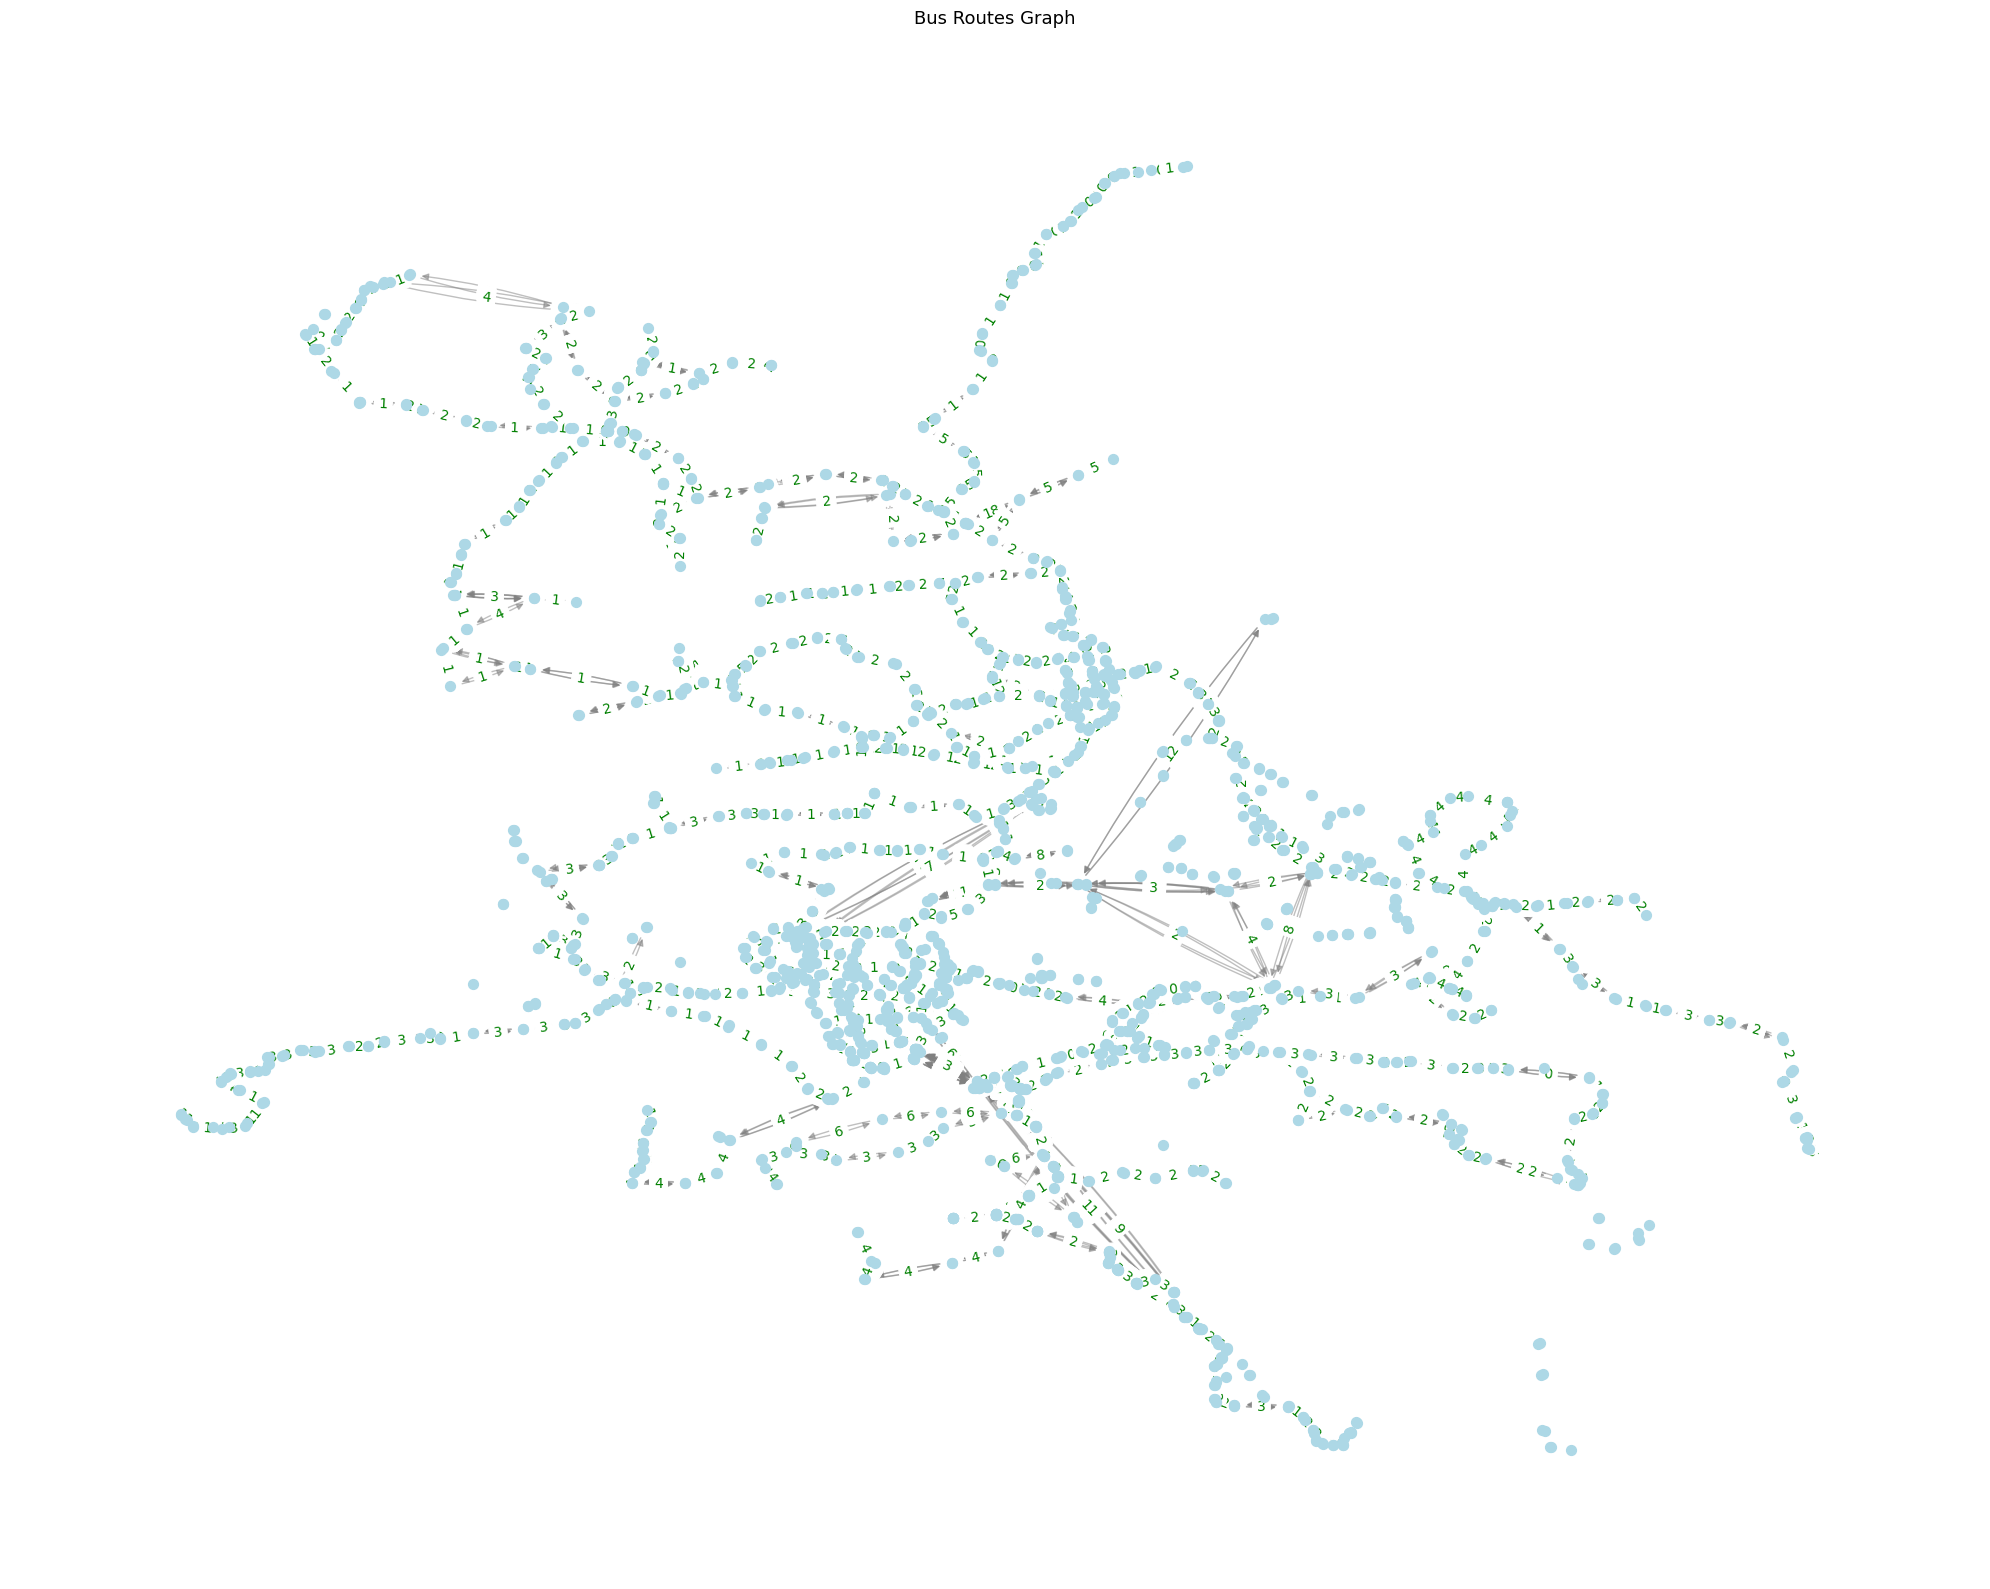

In [4]:
plot_bus_graph(G)

In [6]:
A

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(1995, 1995))

In [5]:
A = nx.to_numpy_array(G, nodelist= nodes, weight='weight',)

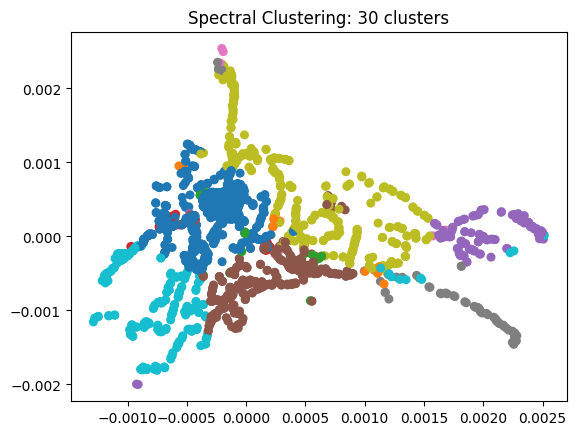

In [7]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import SpectralClustering

nodes = list(G.nodes())
coords = np.array([ [G.nodes[n]['x'], G.nodes[n]['y']] for n in nodes ])

# 1) 원래 adjacency
A = nx.to_numpy_array(G, nodelist= nodes, weight='weight',)

# 2) 좌표 거리 기반 affinity (RBF kernel)
dist = cdist(coords, coords)
sigma = np.mean(dist)
K = np.exp(-dist**2 / (2*sigma**2))

# 3) 섞어주기
alpha, beta = 1.0, 1.0
W = alpha*A + beta*K

n_clusters = 30
sc = SpectralClustering(
    n_clusters=n_clusters,
    affinity='precomputed',
    assign_labels='discretize',  # 또는 'discretize'
    random_state=0
)
cluster_labels = sc.fit_predict(W)  # (num_nodes,)

# 시각화
emb2d = SpectralEmbedding(
    n_components=2,
    affinity='precomputed'
).fit_transform(W)

plt.scatter(emb2d[:,0], emb2d[:,1],
            c=cluster_labels,
            cmap='tab10',
            s=30)
plt.title(f"Spectral Clustering: {n_clusters} clusters")
plt.show()

In [ ]:
import random
import numpy as np
import networkx as nx
from sklearn.decomposition import TruncatedSVD


def generate_walks(G, num_walks=10, walk_length=30):
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)
        for start in nodes:
            walk = [start]
            for _ in range(walk_length-1):
                nbrs = list(G.neighbors(walk[-1]))
                if not nbrs: break
                walk.append(random.choice(nbrs))
            walks.append(walk)
    return walks

def build_cooccurrence_matrix(walks, window_size=5):
    # 노드 → 인덱스 매핑
    uniq = sorted({n for walk in walks for n in walk})
    idx = {n:i for i,n in enumerate(uniq)}
    N = len(uniq)
    C = np.zeros((N, N), dtype=np.float32)

    for walk in walks:
        for i, u in enumerate(walk):
            ui = idx[u]
            # 윈도우 내에서 공기 행렬 업데이트
            for j in range(max(0, i-window_size), min(len(walk), i+window_size+1)):
                if i==j: continue
                v = walk[j]
                vi = idx[v]
                C[ui, vi] += 1
    return C, idx

def ppmi_transform(C):
    # PPMI = max(log((C_ij * total) / (row_sum_i * col_sum_j)), 0)
    total = C.sum()
    row = C.sum(axis=1, keepdims=True)
    col = C.sum(axis=0, keepdims=True)
    # 안전하게 로그 계산
    with np.errstate(divide='ignore'):
        M = np.log((C * total) / (row @ col))
    M[np.isneginf(M)] = 0.0
    M[M < 0] = 0.0
    return M

def compute_embeddings(ppmi, dim=32):
    # SVD 분해
    U, S, _ = np.linalg.svd(ppmi, full_matrices=False)
    # U[:, :dim] @ diag(sqrt(S[:dim])) 가 임베딩
    return U[:, :dim] * np.sqrt(S[:dim])

# ──────────────────────────────────────────────────────────────────────────
# 1) 그래프 예시 로드

# 2) 랜덤 워크 생성
walks = generate_walks(G, num_walks=50, walk_length=100)

# 3) 공기 행렬 구축
C, idx = build_cooccurrence_matrix(walks, window_size=5)

uniq = sorted(idx, key=lambda x: idx[x])
pos_arr = np.array([[G.nodes[n]['x'], G.nodes[n]['y']] for n in uniq], dtype=np.float32)

# 4) (선택) PPMI 변환 후 NaN/Inf 처리
M = ppmi_transform(C)
alpha = 1.0
M_aug = np.hstack([M, pos_arr * alpha])
# NaN, +Inf, -Inf 모두 0으로 바꿔 줍니다
M_aug = np.nan_to_num(M_aug, nan=0.0, posinf=0.0, neginf=0.0)

# 5) Truncated SVD
svd = TruncatedSVD(n_components=34, algorithm="randomized", n_iter=7, random_state=0)
embeddings = svd.fit_transform(M_aug)
print("Embeddings shape:", embeddings.shape)

# 6) 노드 순서대로 결과 매핑
#    embeddings[i] 는 uniq[i] 노드의 벡터
nodes = sorted(idx, key=lambda x: idx[x])
print("임베딩 shape:", embeddings.shape)
print("예시, 노드", nodes[0], "벡터:", embeddings[0])

/tmp/ipykernel_1825320/1202655562.py:46: RuntimeWarning: invalid value encountered in divide
  M = np.log((C * total) / (row @ col))


Embeddings shape: (1995, 34)
임베딩 shape: (1995, 34)
예시, 노드 6800001 벡터: [ 1.3248134e+02 -2.1500430e+00  4.7547431e+00  4.6730685e+00
 -3.3852949e+00  1.8063300e+00  8.1109858e+00  2.5353386e+00
 -1.5009820e-01 -5.8045530e+00  2.2639036e+00  7.9880595e-01
 -4.1408162e+00  9.7645845e+00 -5.1998335e-01  1.6301938e+00
  9.7888780e-01 -5.1014304e-01 -8.4460008e-01  1.3050419e-01
  1.2762377e-01 -2.3871846e-02 -5.9772313e-01 -2.8007540e-01
 -1.4907551e-01 -3.6561835e-01 -4.8149523e-01  2.9113719e-01
 -3.1633323e-01  4.6131703e-01 -4.6807975e-01 -7.0386982e-01
 -5.5152339e-01  3.6199635e-01]


In [ ]:
# 6) 클러스터링
kmeans = KMeans(n_clusters=50, random_state=42).fit(embeddings)
labels = kmeans.labels_  # [N]

# 7) 클러스터별 대표 노드 찾기
import numpy as np
representatives = []
for c in range(50):
    idx = np.where(labels == c)[0]
    center = kmeans.cluster_centers_[c]
    rep = idx[np.argmin(np.linalg.norm(embeddings[idx] - center, axis=1))]
    representatives.append(rep)

print("클러스터 대표 노드 인덱스:", representatives)

클러스터 대표 노드 인덱스: [np.int64(811), np.int64(1348), np.int64(1402), np.int64(985), np.int64(1722), np.int64(513), np.int64(1586), np.int64(314), np.int64(543), np.int64(1456), np.int64(441), np.int64(1639), np.int64(1715), np.int64(466), np.int64(862), np.int64(1096), np.int64(216), np.int64(1351), np.int64(251), np.int64(1372), np.int64(960), np.int64(1990), np.int64(1134), np.int64(1600), np.int64(1973), np.int64(668), np.int64(1019), np.int64(489), np.int64(1131), np.int64(1820), np.int64(122), np.int64(1537), np.int64(1602), np.int64(1350), np.int64(1305), np.int64(1638), np.int64(690), np.int64(765), np.int64(370), np.int64(1994), np.int64(1409), np.int64(278), np.int64(1463), np.int64(1465), np.int64(485), np.int64(535), np.int64(1988), np.int64(1766), np.int64(302), np.int64(1585)]


In [28]:
centralList = [stations[i] for i in representatives]

In [15]:
pos = {}
for n in G.nodes():
        x_coord = G.nodes[n].get('x')
        y_coord = G.nodes[n].get('y')
        pos[n] = (x_coord, y_coord)

G.edges[(6800001, 6801982)]

{'route_number': 'Jan-72', 'route_name': 'Jan-72', 'weight': 1}

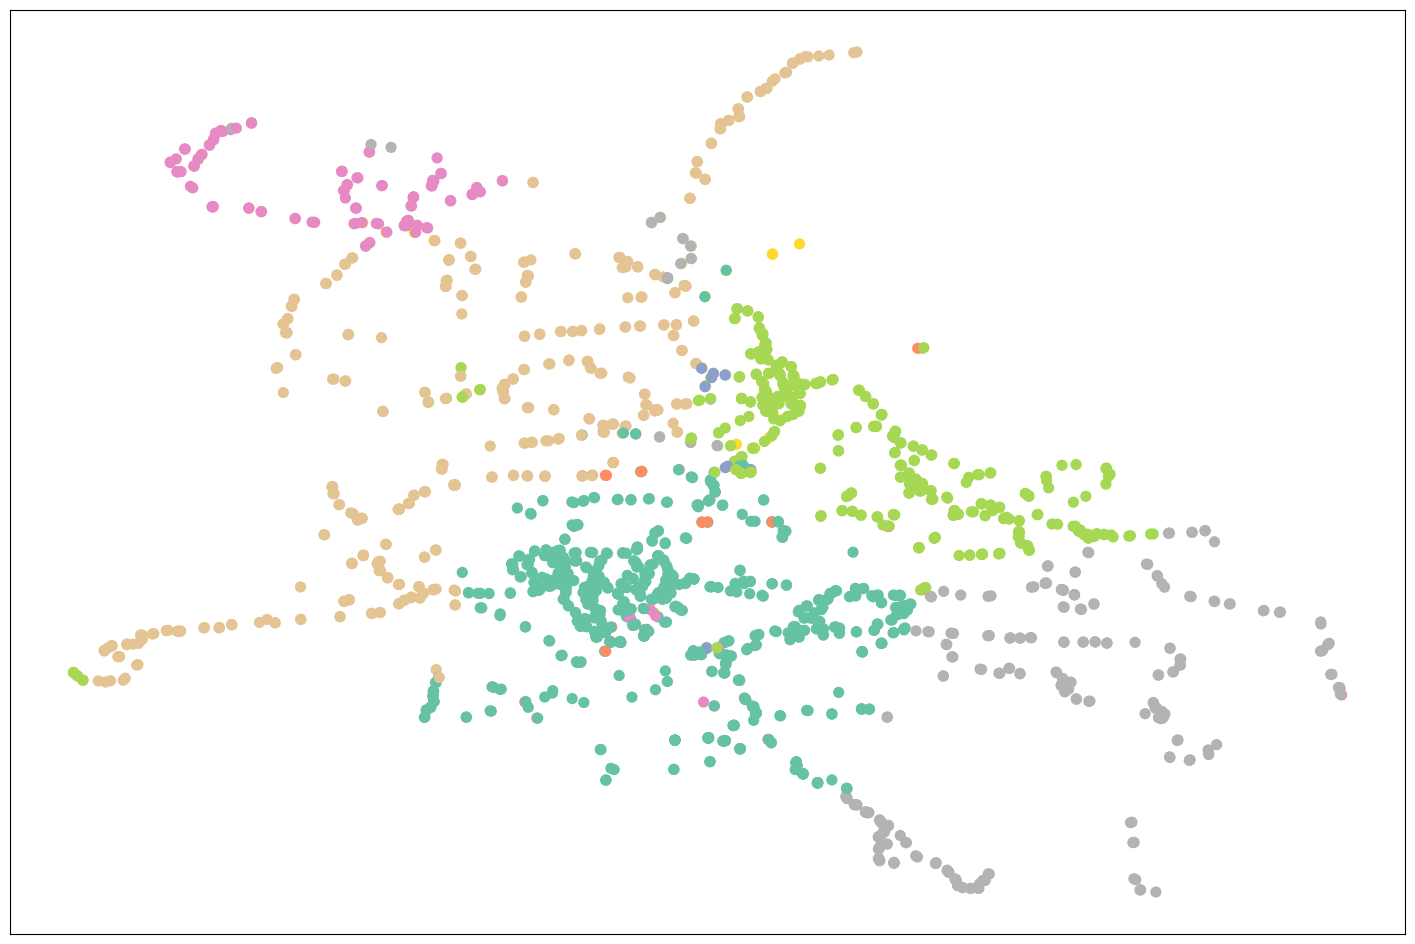

In [16]:
plt.figure(figsize=(18,12))
nx.draw_networkx_nodes(
    G, pos,
    node_size=50,
    node_color=cluster_labels,         # 숫자 리스트
    cmap=plt.cm.Set2,          # Set3 같은 컬러맵
    vmin=min(cluster_labels),
    vmax=max(cluster_labels),
)